# 🛠️ MLflow Hands-On

🎯 **Our goal** is to demonstrate how to integrate **MLflow** into a *machine learning* project, showcasing its role in tracking and managing experiments efficiently.

We'll start by **fitting an initial boosting model**, logging parameters, metrics, and artifacts. Then, we'll move on to **hyperparameter optimization using Optuna**, with the entire workflow tracked and versioned through MLflow.

---------------

🛒 **Dataset**
For this project, we used the **Wholesale Customers Data Set**, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

This dataset provides insights into customer spending habits across different product categories, making it a useful resource for unsupervised learning and clustering tasks.

In [1]:
# ===========================
# 📦 Data Manipulation
# ===========================
import os
import json
import math
import tempfile
import shutil
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

# ===========================
# 📊 Visualization
# ===========================
import matplotlib.pyplot as plt
import seaborn as sns


# ===========================
# 🤖 Modeling and Evaluation
# ===========================
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, log_loss, confusion_matrix, 
    ConfusionMatrixDisplay, mean_squared_error)

# ===========================
# 🔍 Optimization & Tracking
# ===========================
import optuna
import mlflow
import sys
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

# ===========================
# 🛠️ Utilities
# ===========================
import warnings
warnings.filterwarnings('ignore')

## 📥 Import dataset

In [2]:
df = pd.read_csv('Wholesale customers data.csv')
df.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


## 🔍 Checking for missing values

In [3]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

## 🎯 Declare feature vector and target variable

In [4]:
X = df.drop('Channel', axis=1)
# ---
y = df['Channel']
y.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

We can see that the \$y\$ labels currently contain the values \$1\$ and \$2\$. For simplicity and easier interpretation, we will convert them to \$0\$ and \$1\$ for further analysis.

In [5]:
y[y == 2] = 0
y[y == 1] = 1

Now, I will convert the dataset into an optimized data structure called **Dmatrix** that XGBoost supports and gives it acclaimed performance and efficiency gains

In [6]:
data_dmatrix = xgb.DMatrix(data=X, label=y)

## ✂️ Split data into separate training and test set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## 🔧 Train the XGBoost Classifier

Now it's time to train our **XGBoost classifier**!
Before we begin, it’s important to understand the different types of parameters that XGBoost offers. These parameters control the model’s behavior, performance, and complexity.

There are **four main categories** of parameters you should know:


### ⚙️ General parameters

These define which **booster type** to use (e.g., tree-based or linear).
Common options include:

* `gbtree` – tree-based models (default)
* `gblinear` – linear models
* `dart` – tree-based models with dropout


### 🌲 Booster parameters

These depend on the selected booster type and control the training process of individual trees or models.


### 🎯 Learning task parameters

These define the **objective function** and the type of learning task (e.g., regression, classification, ranking).

### 💻 Command line parameters

These relate to the CLI (Command Line Interface) version of XGBoost, and aren’t usually needed when using the Python API.


## 🧠 Key Parameters to know

Here are some of the most important parameters you'll likely tune:

* **`learning_rate`** – Controls the step size shrinkage to prevent overfitting. Range: `[0, 1]`.
* **`max_depth`** – Maximum depth of a tree. Deeper trees can capture more complex patterns.
* **`subsample`** – Fraction of the training data to use for each tree. Lower values can help prevent overfitting.
* **`colsample_bytree`** – Fraction of features to use for each tree. Higher values may lead to overfitting.
* **`n_estimators`** – Number of boosting rounds (i.e., trees).
* **`objective`** – Specifies the learning task and the corresponding loss function:

  * `reg:squarederror` – for regression
  * `binary:logistic` – for binary classification (probability output)
  * `reg:logistic` – for classification with decision outputs


## 🛡️ Regularization parameters

XGBoost also offers regularization to reduce model complexity and avoid overfitting:

* **`gamma`** – Minimum loss reduction required to make a split. Higher values result in fewer splits.
* **`alpha`** – L1 regularization term on weights (Lasso). Encourages sparsity.
* **`lambda`** – L2 regularization term on weights (Ridge). Adds smoothness.

Even though we're using **trees as base learners**, XGBoost also supports linear models (`gblinear`) and dropout-based trees (`dart`) via the `booster` parameter.

---

Imagine you're a data scientist, and it's time to fine-tune your machine learning model. Fortunately, after some experimentation, you’ve found that the parameter combination below delivers a satisfactory performance for your classification task.


In [8]:
params = {
    # Target function for binary classification
    'objective': 'binary:logistic',

    # Evaluation metric
    'eval_metric': 'logloss',

    # Booster type (default is 'gbtree')
    'booster': 'gbtree',

    # Learning rate (step size shrinkage)
    'learning_rate': 0.1,

    # Maximum depth of each tree
    'max_depth': 3,

    # Subsample ratio of the training instances
    'subsample': 0.8,

    # Subsample ratio of columns for each tree
    'colsample_bytree': 0.8,

    # L2 regularization term on weights (Ridge)
    'lambda': 1.0,

    # L1 regularization term on weights (Lasso)
    'alpha': 0.0}

#------------------

# Instantiate the classifier
xgb_clf = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
print(xgb_clf)


XGBClassifier(alpha=0.0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1.0,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)


## 🔮 Make Predictions with XGBoost Classifier

In [9]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test)

## ✅ Check Accuracy Score

Accuracy:  0.8939
Precision: 0.8913
Recall:    0.9535
f1-Score:  0.9213
AUC:       0.9626


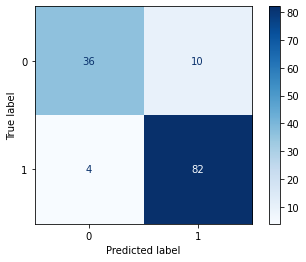

In [10]:
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])

# Print scores
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'f1-Score:  {f1:.4f}')
print(f'AUC:       {auc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

## 🔍 Feature importance with XGBoost

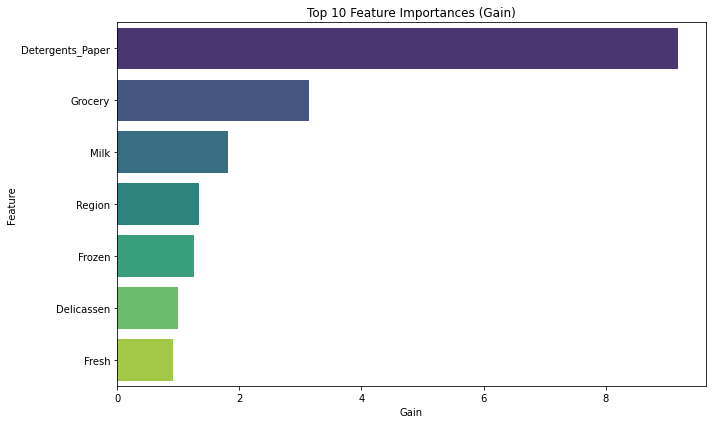

In [11]:
importances = xgb_clf.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

# Optional: show only top N features
top_n = 10
importance_df = importance_df.head(top_n)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f"Top {top_n} Feature Importances (Gain)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


------------

📦 **Project Handoff to MLOps**

Now, imagine this is the final output of a data scientist's work. This project will be handed over to a machine learning engineer, who will be responsible for versioning the model using MLflow.

The engineer will set up experiment tracking, store the generated artifacts, monitor model performance metrics, and ensure the entire workflow is reproducible all as part of a well-structured MLOps pipeline.

🎯 **Next Step: Hyperparameter Optimization**

From this point on, we will perform hyperparameter optimization using Optuna. Meanwhile, MLflow will continue to log each experiment, allowing us to compare versions and easily identify the best set of parameters.


---------

## ⚙️ MLOps in Practice: Managing the Machine Learning Model Lifecycle

Now, we explore how **MLOps** practices help structure, automate, and scale the machine learning model lifecycle — from data preparation and model training to deployment, monitoring, and continuous improvement. We'll demonstrate how tools like **MLflow** can streamline this process and ensure reproducibility, traceability, and collaboration across teams.

## 🚀 Initializing the MLflow Server

To start the MLflow tracking server locally, follow the steps based on your environment:

---

### 🐍 **Using Anaconda**

1. Open the **Anaconda Command Prompt**  
2. Navigate to your project directory:

   ```bash
   cd your-project-path

3. Run the MLflow server:

   ```bash
   python -m mlflow server --host 127.0.0.1 --port 8282


### 💻 **Using VS Code**

1. Open the **terminal** in VS Code
2. Run the command below:

   ```bash
   py -m mlflow server --host 127.0.0.1 --port 8282

✅ Make sure you're using the same Python environment or kernel as the one used in your notebook or training script.

-----

🛰️  Now, let's define the address of the MLflow tracking server — that is, where the experiment logs (parameters, metrics, models, etc.) will be sent and stored.

In [12]:
mlflow.set_tracking_uri('http://127.0.0.1:8282')

Access the URL above from a new tab in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


## 📈 **Monitoring the Trained Model**

To properly monitor the performance of the trained model, we will generate a series of visualizations that will help us better understand how the model is behaving.

These plots will assist in:

* Evaluating predictive quality
* Identifying potential bias or imbalance
* Detecting signs of overfitting or underfitting
* Supporting model explainability and transparency

By visualizing key metrics and outputs, we can gain valuable insights that go beyond raw numbers and ensure the model remains reliable over time.

In [13]:
def plot_corr(df, target='Channel', save_path=None, top_n=None):
    '''
    Parameters:
    - df: pandas DataFrame containing the dataset
    - target: string, name of the target column
    - save_path: optional path to save the figure (as PNG)
    - top_n: optional, number of top features to display based on absolute correlation
    '''
    # Compute correlations with the target 
    corr = df.corr()[target].drop(target)
    corr = corr.reindex(corr.abs().sort_values().index)

    # Optionally show only top N correlated features
    if top_n:
        corr = corr.tail(top_n)

    # Set clean white style
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 0.5 * len(corr) + 1))

    # Plot horizontal bars with elegant color
    bars = ax.barh(
        corr.index, corr.values,
        color='#4C72B0', edgecolor='black', height=0.6
    )

    # Add correlation values next to bars
    for bar in bars:
        width = bar.get_width()
        ax.text(
            x=width + 0.02 if width > 0 else width - 0.02,
            y=bar.get_y() + bar.get_height() / 2,
            s=f"{width:.2f}",
            va='center',
            ha='left' if width > 0 else 'right',
            fontsize=11)

    # Clean and minimal axes
    ax.set_title(f"Correlation with '{target}'", fontsize=16, pad=12)
    ax.set_xlabel("Correlation Coefficient", fontsize=13)
    ax.set_ylabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    # Save figure if needed
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.close(fig)
    return fig


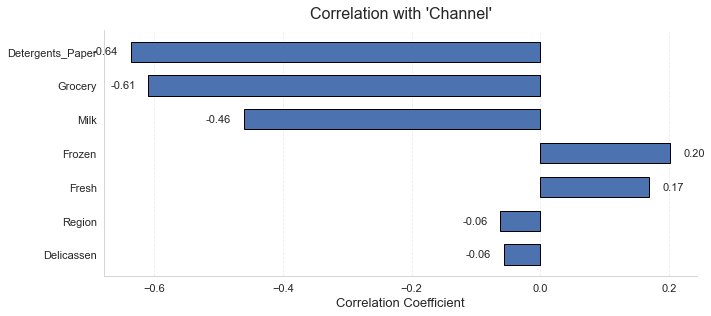

In [14]:
plot_corr(df)

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels=None, save_path=None):
    '''
    Plots a styled confusion matrix with annotated counts.

    Parameters:
    - y_true: array-like, true target labels
    - y_pred: array-like, predicted labels
    - labels: optional list of label names (for axis ticks)
    - save_path: optional path to save the figure as PNG
    '''
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set seaborn style
    sns.set_style('whitegrid', {
        'axes.facecolor': '#eaeaf2',
        'grid.linewidth': 1.2})

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        cbar=False, square=True, linewidths=0.5,
        xticklabels=labels if labels else 'auto',
        yticklabels=labels if labels else 'auto',
        ax=ax)

    # Titles and labels
    ax.set_title('Confusion Matrix', fontsize=16, pad=12)
    ax.set_xlabel('Predicted Labels', fontsize=13)
    ax.set_ylabel('True Labels', fontsize=13)
    ax.tick_params(axis='both', labelsize=12)

    # Adjust layout
    plt.tight_layout()

    # ✅ Save if path provided
    if save_path:
        fig.savefig(save_path, format="png", dpi=600, bbox_inches='tight')

    # Close and return
    plt.close(fig)
    return fig


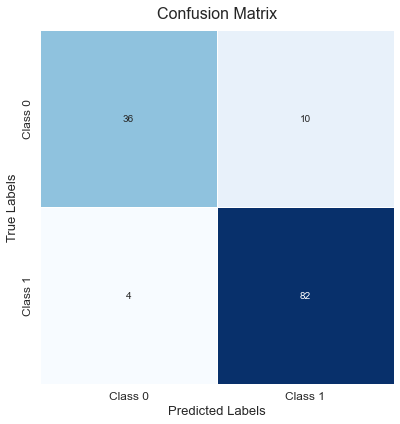

In [16]:
plot_confusion_matrix(y_test, y_pred, labels=['Class 0', 'Class 1'])

In [17]:
def plot_feature_importance(model, booster='gbtree', top_n=10, importance_type=None, save_path=None):
    '''
    Plots feature importance for a trained XGBoost model (either Booster or XGBClassifier).
    '''
    if importance_type is None:
        importance_type = 'weight' if booster == 'gblinear' else 'gain'

    # Handle both Booster and XGBClassifier
    if hasattr(model, 'get_booster'):
        booster_model = model.get_booster()
    else:
        booster_model = model  # assume it's already a Booster

    # Extract feature importances
    importances = booster_model.get_score(importance_type=importance_type)

    importance_df = pd.DataFrame({
        'Feature': list(importances.keys()),
        'Importance': list(importances.values())
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    sns.set_style('white')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')

    plt.title(f'Top {top_n} Feature Importances ({importance_type.title()})', fontsize=14)
    plt.xlabel(importance_type.title(), fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

    fig = plt.gcf()
    plt.close()
    return fig


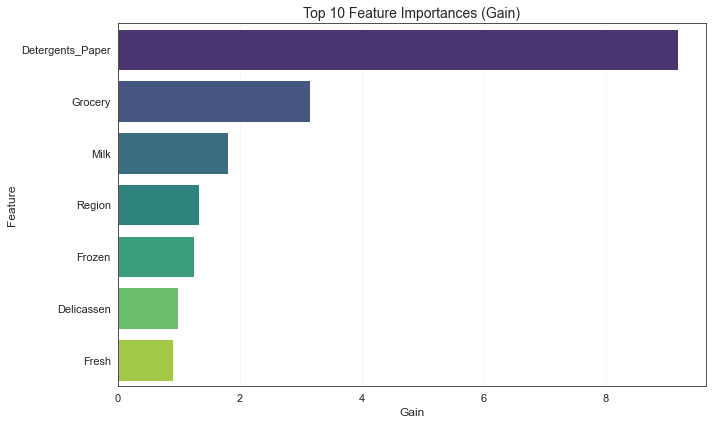

In [18]:
plot_feature_importance(xgb_clf, booster='gbtree', top_n=10, importance_type=None, save_path=None)

## 🧪 Creating the experiment in MLflow

In [19]:
# Function to create an MLflow experiment
def create_experiment(experiment_name):
    '''
    Creates an MLflow experiment if it doesn't already exist.
    
    Parameters:
    - experiment_name: string, name of the experiment to create or retrieve
    
    Returns:
    - experiment_id: the ID of the existing or newly created experiment
    '''

    # Check if the experiment already exists by name
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # If it exists, return its ID
        return experiment.experiment_id
    else:
        # If it doesn't exist, create a new one and return its ID
        return mlflow.create_experiment(experiment_name)

In [20]:
# creating the experiment
id_experiment = create_experiment('mlflow-project')
print(f'The ID of experiment is: {id_experiment}')

The ID of experiment is: 141944350772008914


View it in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


## 🛠️ Fine-tuning the model

🔍 Imagine your job is to monitor the performance of a model developed by **the data scientist**.\
🚀 Since you also have data science skills, you decide to take it a step further by optimizing the model’s **hyperparameters**.\
🧠 You know that, for the tuning to be meaningful and leakage-free, you must work with three separate datasets:
🏋️ The **training set** is used to adjust the model’s weights.\
🧪 The **validation set** helps you compare different hyperparameter configurations without touching the test set.\
🎯 The **test set** remains untouched until the final evaluation, ensuring that performance is measured on truly unseen data.\
✅ This setup ensures reliable, reproducible results and a model ready for production.


In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fixed split into training and validation for all trials
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0)

🤖✨ **Why Use a Validation Set for Hyperparameter Tuning?** ✨🔍

When performing **hyperparameter tuning** (e.g., with Optuna), it's essential to split your data into three sets: **training**, **validation**, and **test**. Here’s why:

---

1. 🔒 **Avoid Information Leakage**

   * If you only use *train* and *test* and choose hyperparameters based on the *test* set, you're leaking information — meaning you've tuned for the *test* instead of truly measuring generalization.
   * 🛑 The **test** set must remain **untouched** until final evaluation, simulating truly unseen data.

2. 🎯 **Tune Using a Separate Set**

   * **Training set:** fits the model’s weights.
   * **Validation set:** compares different configurations (number of trees, depth, learning rate, etc.) without touching the *test* set.
   * ✅ Only after selecting the best configuration on the *validation* set should you “freeze” the model and evaluate it on the *test* set.

3. 🔄 **Reproducibility Across Trials**

   * By using the same *(X\_train, X\_valid)* split for **all** trials, you ensure that the only change Optuna sees is the **hyperparameter**, not a new data partition each time.
   * This makes comparisons between trials fairer and more stable.

4. 📊 **Typical Data Split**

   * `test_size=0.3` → 30% of the data is allocated to the **final test**.
   * Of the remaining 70%, using `test_size=0.2` gives 14% for **validation**, and 56% remains for **training**.
   * In summary:

     * 🏋️ **Training:** 56%
     * 🔎 **Validation:** 14%
     * 🎯 **Test:** 30%

---

### 🚀 Ideal Tuning Pipeline Flow

1. 🪓 **3-way split:** `train` ↔ `validation` ↔ `test`
2. ⚙️ **Hyperparameter optimization** using **train + validation**
3. 🏋️ **Final training** with the best configuration on **train + validation**
4. 🎯 **Final evaluation** on the **test** set (unseen data)

---

✅ **Benefits:**

* The model **doesn’t overfit** to the test set.
* Hyperparameter selection is **truly generalizable**.
* The final evaluation reflects the model’s **true performance** on new data.

You're now running a tuning process that’s leakage-proof and free from biased comparisons. 😉👍


## 🎯 Maximizing F1-Score for Balanced Performance


Here, we chose to **maximize the F1-score** as our objective in order to ensure a balanced and meaningful performance metric.


In [22]:
def optimize_hyperparameters(trial):
    # Convert to DMatrix
    dsubtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dvalid   = xgb.DMatrix(X_valid.values, label=y_valid.values)

    # Hyperparameter search space
    params = {
        'objective':        'binary:logistic',
        'eval_metric':      'logloss',
        'booster':          trial.suggest_categorical('booster', ['gbtree','gblinear','dart']),
        'learning_rate':    trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda':       trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha':        trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)}

    # Each trial is a nested run in MLflow
    with mlflow.start_run(nested=True):
        model = xgb.train(
            params,
            dsubtrain,
            evals=[(dvalid, 'validation')],
            num_boost_round=1000,
            early_stopping_rounds=20,
            verbose_eval=False
        )

        # Evaluate on the validation set
        preds_proba = model.predict(dvalid)
        preds       = (preds_proba > 0.5).astype(int)
        f1          = f1_score(y_valid, preds)

        # Log parameters and metric to MLflow
        mlflow.log_params(params)
        mlflow.log_metric('f1_score', f1)

    # Optuna minimizes the objective, so return 1 - f1_score
    return 1.0 - f1

## 🏆 Tracking the Best F1-Score During Optimization

This callback monitors each trial and updates the current best F1-score. Whenever a new trial achieves a better score, it logs the result and stores it as the new winner, helping track progress in real time.


In [23]:
def f1_score_callback(study, frozen_trial):
    previous_best = study.user_attrs.get('winner', None)
    current_value = 1.0 - frozen_trial.value  # Convertendo para F1-score
    trial_number = frozen_trial.number

    if previous_best is None:
        study.set_user_attr('winner', current_value)
        print(f'Tentativa inicial {trial_number} alcançou o valor: {current_value:.4f} na métrica de avaliação.')
    elif current_value > previous_best:
        improvement = 100 * (current_value - previous_best) / previous_best
        print(f'Tentativa {trial_number} alcançou o valor: {current_value:.4f} com  {improvement:.4f}% de melhora na métrica de avaliação.')
        study.set_user_attr('winner', current_value)

In [24]:
def f1_score_callback(study, frozen_trial):
    current_winner = study.user_attrs.get('winner', None)
    if study.best_value is not None and current_winner != study.best_value:
        study.set_user_attr('winner', study.best_value)
        print(f'New best F1-score: {1.0 - study.best_value:.4f} '
              f'on trial {frozen_trial.number}')

## 🧪 Full Training and Evaluation Pipeline with MLflow & Optuna

This script performs a complete machine learning workflow: it starts an MLflow run, optimizes hyperparameters with Optuna, logs the best trial's results, trains the final model using both training and validation data, and evaluates it on a held-out test set. Performance metrics (accuracy, precision, recall, F1-score) and the confusion matrix are logged. Finally, the model is saved with its signature for proper versioning in MLflow’s Model Registry.

In [25]:
run_name = 'experiment_1'
mlflow.set_experiment(experiment_id=id_experiment)

with mlflow.start_run(run_name=run_name):
    # Hyperparameter optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize_hyperparameters, n_trials=200, callbacks=[f1_score_callback])

    # Log best trial and F1-score as tags
    mlflow.set_tag('best_f1_score', f'{1.0 - study.best_value:.4f}')
    mlflow.set_tag('best_trial',    str(study.best_trial.number))

    # Final training using full train + validation data
    dtrainval = xgb.DMatrix(X_trainval.values, label=y_trainval.values)
    dtest     = xgb.DMatrix(X_test.values,      label=y_test.values)

    final_model = xgb.train(
        study.best_params,
        dtrainval,
        evals=[(dtest, 'test')],
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=False)

    # Evaluation on the test set
    y_pred_test   = final_model.predict(dtest)
    y_pred_binary = (y_pred_test >= 0.5).astype(int)

    acc  = accuracy_score(y_test, y_pred_binary)
    prec = precision_score(y_test, y_pred_binary)
    rec  = recall_score(y_test, y_pred_binary)
    f1   = f1_score(y_test, y_pred_binary)

    mlflow.log_metric('final_accuracy',  acc)
    mlflow.log_metric('final_precision', prec)
    mlflow.log_metric('final_recall',    rec)
    mlflow.log_metric('final_f1_score',  f1)

    # Confusion matrix 
    fig_path = os.path.join(tempfile.gettempdir(), 'confusion_matrix.png')
    plot_confusion_matrix(y_test, y_pred_binary, save_path=fig_path)
    mlflow.log_artifact(fig_path)

    # Correlation
    corr_path = os.path.join(tempfile.gettempdir(), 'correlation.png')
    plot_corr(df, target='Channel', save_path=corr_path)
    mlflow.log_artifact(corr_path)
    plt.close()

    # Feature importance
    fi_path = os.path.join(tempfile.gettempdir(), 'feature_importance.png')
    plot_feature_importance(
    model=final_model,
    booster="gbtree",
    top_n=10,
    importance_type=None,
    save_path=fi_path)
    mlflow.log_artifact(fi_path)
    plt.close()

    # Model signature inference for MLflow Model Registry
    signature = infer_signature(X_trainval, final_model.predict(dtrainval))

    # Save the final model
    tmp_dir         = tempfile.mkdtemp()
    model_save_path = os.path.join(tmp_dir, 'model')

    mlflow.xgboost.save_model(
        final_model,
        path=model_save_path,
        input_example=X_trainval.iloc[[0]],
        signature=signature,
        model_format='ubj',
        metadata={'model_data_version': 1})
    
    mlflow.log_artifacts(model_save_path, artifact_path='model')
    shutil.rmtree(tmp_dir)

print('-- Done --')

[I 2025-07-21 17:35:24,916] A new study created in memory with name: no-name-35d58801-861c-442b-9645-9568a456140b
[I 2025-07-21 17:35:25,499] Trial 0 finished with value: 0.08433734939759041 and parameters: {'booster': 'gbtree', 'learning_rate': 0.1901144179595178, 'max_depth': 8, 'subsample': 0.6047664049724204, 'colsample_bytree': 0.696322801469128, 'reg_lambda': 0.0019645428020052635, 'reg_alpha': 5.010495998762827e-06}. Best is trial 0 with value: 0.08433734939759041.


🏃 View run nebulous-hound-37 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/eb57220dde0f47e9909005c17ee2e634
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914
New best F1-score: 0.9157 on trial 0


[I 2025-07-21 17:35:26,355] Trial 1 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.290908938571973, 'max_depth': 8, 'subsample': 0.5815294323144793, 'colsample_bytree': 0.8704850440777943, 'reg_lambda': 2.8770741452268377e-07, 'reg_alpha': 1.5984315810227978e-06}. Best is trial 1 with value: 0.07317073170731703.


🏃 View run bittersweet-seal-715 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/4594d3523f55435ba21f22734e8e14df
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914
New best F1-score: 0.9268 on trial 1


[I 2025-07-21 17:35:26,798] Trial 2 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.22801703336628565, 'max_depth': 3, 'subsample': 0.620095758003444, 'colsample_bytree': 0.955750370448049, 'reg_lambda': 0.51340217446063, 'reg_alpha': 0.01856781576973547}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run silent-croc-97 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/f541c95f049841029fb0f72e74617ba7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914
New best F1-score: 0.9367 on trial 2


[I 2025-07-21 17:35:27,217] Trial 3 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0584398044181858, 'max_depth': 4, 'subsample': 0.7735015251990985, 'colsample_bytree': 0.9290767472702224, 'reg_lambda': 0.05731404297226963, 'reg_alpha': 0.010461424693825135}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run legendary-carp-881 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/be402ea9e08d4e79ae0cb8572582e4b5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:27,593] Trial 4 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.10475931895103886, 'max_depth': 4, 'subsample': 0.8890066689486966, 'colsample_bytree': 0.893476232244673, 'reg_lambda': 0.2767879534224688, 'reg_alpha': 1.7892619617937417e-05}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run amazing-koi-378 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/cc5748a0892c48eb9febf9cf34917c42
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:28,022] Trial 5 finished with value: 0.07499999999999996 and parameters: {'booster': 'dart', 'learning_rate': 0.2083323231235934, 'max_depth': 7, 'subsample': 0.6395846891068377, 'colsample_bytree': 0.5332365129699257, 'reg_lambda': 2.732394684370138e-06, 'reg_alpha': 0.08110648635136392}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run rumbling-pig-859 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/90555f120cc043eb9401894f8b810c0a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:28,625] Trial 6 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.01777767841090124, 'max_depth': 8, 'subsample': 0.5455620194654762, 'colsample_bytree': 0.7239167057022782, 'reg_lambda': 3.464183484602345e-05, 'reg_alpha': 0.13171362991045343}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run stylish-grouse-646 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/fd7a0a42610c499cba40a1a81212452d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:29,017] Trial 7 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.12993334380659394, 'max_depth': 3, 'subsample': 0.8203084710140734, 'colsample_bytree': 0.6217388334851379, 'reg_lambda': 1.837456092937041e-07, 'reg_alpha': 9.3054658388488e-06}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run auspicious-fish-996 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/34779f5e0c1d4aed8a8a71d7358f5db2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:30,028] Trial 8 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.04930037835845499, 'max_depth': 5, 'subsample': 0.7239266290761719, 'colsample_bytree': 0.7492965559363616, 'reg_lambda': 1.907442791731701e-08, 'reg_alpha': 7.081075633405104e-08}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run indecisive-pig-501 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/3e88c46f951c4e859328ef498b8d9f15
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:30,411] Trial 9 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2386181802671137, 'max_depth': 5, 'subsample': 0.5736149848762773, 'colsample_bytree': 0.6931315367240466, 'reg_lambda': 3.253028259582786e-05, 'reg_alpha': 2.8958809776773786e-05}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run flawless-panda-556 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/23c7d43d9fff415a999a342113769f07
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:30,844] Trial 10 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.2816978357730736, 'max_depth': 6, 'subsample': 0.9966741441162319, 'colsample_bytree': 0.9841183027773591, 'reg_lambda': 0.0038345976298119087, 'reg_alpha': 0.0027284478865475708}. Best is trial 2 with value: 0.06329113924050633.


🏃 View run suave-shrimp-939 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/dc7fb5f7d4824a29be7d12c6f8f44cbc
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:31,241] Trial 11 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08477894916203584, 'max_depth': 3, 'subsample': 0.7111276140044976, 'colsample_bytree': 0.996143543062813, 'reg_lambda': 0.8426092038973336, 'reg_alpha': 0.002095321676701359}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run flawless-mule-434 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7e392d9bb9a247c9b5fcdc15aee6974b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914
New best F1-score: 0.9487 on trial 11


[I 2025-07-21 17:35:31,707] Trial 12 finished with value: 0.07499999999999996 and parameters: {'booster': 'dart', 'learning_rate': 0.16972554645937973, 'max_depth': 10, 'subsample': 0.6839553425663091, 'colsample_bytree': 0.8185004992706932, 'reg_lambda': 0.27091998959641733, 'reg_alpha': 0.0005596122204829351}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run gifted-fox-723 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/c80ca00e7b934702ab1418c36f6960ef
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:32,463] Trial 13 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.09826483137745645, 'max_depth': 3, 'subsample': 0.5046757687843759, 'colsample_bytree': 0.9988647396524113, 'reg_lambda': 0.010070330553790379, 'reg_alpha': 0.8093218921988135}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run capricious-toad-748 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/e88e72f760da49e0b00622ce691dd3bb
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:32,859] Trial 14 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.23438685294245903, 'max_depth': 3, 'subsample': 0.6722112300937202, 'colsample_bytree': 0.8177800863996649, 'reg_lambda': 0.9206068226132476, 'reg_alpha': 0.00024882829101628023}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run adventurous-newt-972 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/4651a2c4d1154e2b9d86e28eed0788ea
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:33,256] Trial 15 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.13704972809971275, 'max_depth': 4, 'subsample': 0.7942319023584653, 'colsample_bytree': 0.9416732043013093, 'reg_lambda': 0.00045006462015992837, 'reg_alpha': 0.024718735126395733}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run puzzled-skunk-464 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/00ccad6b22e8433b8f75eb97761aa339
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:33,923] Trial 16 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.08762974069052756, 'max_depth': 5, 'subsample': 0.727063178562088, 'colsample_bytree': 0.84045654815635, 'reg_lambda': 0.04561768003465822, 'reg_alpha': 0.0017861407757756528}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run adorable-boar-289 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d249825cdded46078d161db92ec4d882
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:34,388] Trial 17 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.25414477835238947, 'max_depth': 10, 'subsample': 0.8583052913786076, 'colsample_bytree': 0.9394767975468222, 'reg_lambda': 0.034208163601734794, 'reg_alpha': 0.9826114931312975}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run polite-foal-140 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0c7f2bf4206e41808a8f8d3e62e33f48
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:34,756] Trial 18 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.1624409417203801, 'max_depth': 6, 'subsample': 0.6469957137398247, 'colsample_bytree': 0.9953960192643592, 'reg_lambda': 0.0004888203469749614, 'reg_alpha': 0.005601753184210588}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run adorable-duck-550 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b1e67ada1cad418ba0ef2f00ee4a44e1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:35,123] Trial 19 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.19759444578123092, 'max_depth': 3, 'subsample': 0.7084904603656911, 'colsample_bytree': 0.7831702247990786, 'reg_lambda': 0.9680155069392153, 'reg_alpha': 0.00012375662715461571}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run awesome-moose-127 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8bd64378df724a609503ab8ca7e8dbf5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:36,072] Trial 20 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.05762138140942563, 'max_depth': 4, 'subsample': 0.9274104335530067, 'colsample_bytree': 0.8978042692218063, 'reg_lambda': 0.1297729283743902, 'reg_alpha': 4.131829207126209e-07}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run overjoyed-owl-983 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/58d4f78cba754954b67e41e0ca28ea1c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:36,489] Trial 21 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05831251926753406, 'max_depth': 4, 'subsample': 0.7756680226650713, 'colsample_bytree': 0.9393335563210514, 'reg_lambda': 0.0506582099320126, 'reg_alpha': 0.01475667054219723}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run capricious-deer-118 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/6a35e8ff846947ef9a7af3abc790bff8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:36,942] Trial 22 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.02335456619486396, 'max_depth': 3, 'subsample': 0.749995950921521, 'colsample_bytree': 0.9541499853145442, 'reg_lambda': 0.9775481628590317, 'reg_alpha': 0.062220864562425385}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run aged-hound-598 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2859309079da4df1b68ec3d5c87d2aa8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:37,363] Trial 23 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.12450060347513328, 'max_depth': 4, 'subsample': 0.8222974393510184, 'colsample_bytree': 0.8724568080276356, 'reg_lambda': 0.010886108330517957, 'reg_alpha': 0.0009259663031062525}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run abundant-slug-57 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/60bd9c5df241486ba1bdb947fae7a70b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:37,773] Trial 24 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08058657362565086, 'max_depth': 5, 'subsample': 0.626810671632656, 'colsample_bytree': 0.9144209169525792, 'reg_lambda': 0.10796333733551958, 'reg_alpha': 0.013095027390779744}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run vaunted-ray-39 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/81d59640f41f4da6b8366029a4357070
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:38,207] Trial 25 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06621256934270017, 'max_depth': 5, 'subsample': 0.6839627839360586, 'colsample_bytree': 0.9035910586519854, 'reg_lambda': 0.019605091829798724, 'reg_alpha': 0.21054000119026264}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run casual-rat-965 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8aa6de5ef51249dabbdf1d58de4d6bf0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:38,627] Trial 26 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08481905900785451, 'max_depth': 6, 'subsample': 0.7521428838473555, 'colsample_bytree': 0.8478169099540408, 'reg_lambda': 0.11989342575848554, 'reg_alpha': 0.0038465345828387213}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run fearless-elk-789 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/81956288586e46e8a1b325cfb7642608
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:39,073] Trial 27 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0340649844695919, 'max_depth': 5, 'subsample': 0.7982428111145574, 'colsample_bytree': 0.9723616185190078, 'reg_lambda': 0.0016280722779648306, 'reg_alpha': 6.134562596853691e-05}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run industrious-shad-885 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0d67eba39b6d4f63b3fa1c3943f67f31
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:39,505] Trial 28 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.079355065604104, 'max_depth': 4, 'subsample': 0.6594901224848331, 'colsample_bytree': 0.9155500820047757, 'reg_lambda': 0.00024233394154741936, 'reg_alpha': 0.0005441083657923532}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run resilient-mule-528 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9f828afefbf042b883ee6716d9958ff1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:39,908] Trial 29 finished with value: 0.09756097560975607 and parameters: {'booster': 'gbtree', 'learning_rate': 0.1118523176699808, 'max_depth': 7, 'subsample': 0.6134788216944123, 'colsample_bytree': 0.6124061540682417, 'reg_lambda': 0.0035552472923376646, 'reg_alpha': 0.027898592844623135}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run selective-stork-444 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2173ed5ba58745b9b97800e05e73da78
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:40,339] Trial 30 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04105599363122254, 'max_depth': 6, 'subsample': 0.8606512755979474, 'colsample_bytree': 0.7892179964131463, 'reg_lambda': 0.13079428702837081, 'reg_alpha': 0.2796866562921363}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run classy-lynx-507 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/6310bcde526b4e8bbf12549e903e641b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:40,722] Trial 31 finished with value: 0.07317073170731703 and parameters: {'booster': 'gbtree', 'learning_rate': 0.1522699324411052, 'max_depth': 3, 'subsample': 0.6025451232036814, 'colsample_bytree': 0.9602737659775541, 'reg_lambda': 0.2596336827636927, 'reg_alpha': 0.021968768252693848}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run vaunted-moose-945 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2c460e3e39da480290e4eee8e233d22d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:41,122] Trial 32 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.07087546174067945, 'max_depth': 4, 'subsample': 0.5450017861006051, 'colsample_bytree': 0.9639496911811272, 'reg_lambda': 0.39236463282656114, 'reg_alpha': 0.0090885119837982}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run dapper-bat-901 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/874e72aa12424cab92dc5ea582b3783e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:41,506] Trial 33 finished with value: 0.07692307692307687 and parameters: {'booster': 'gbtree', 'learning_rate': 0.17633884111685116, 'max_depth': 3, 'subsample': 0.618101885722513, 'colsample_bytree': 0.8730033731977737, 'reg_lambda': 0.05942234824708921, 'reg_alpha': 0.012268882584038278}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run omniscient-calf-363 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b5cd3219e4354879b3baf18931552d1c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:41,930] Trial 34 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.11248975522049093, 'max_depth': 9, 'subsample': 0.7101260075305935, 'colsample_bytree': 0.9280889591824962, 'reg_lambda': 0.013546057645610909, 'reg_alpha': 0.0016295795548779686}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run caring-grouse-128 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/6e8ef18f610e4c4d9fdc7d590b0faf60
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:42,306] Trial 35 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.14334165122851195, 'max_depth': 4, 'subsample': 0.5728595627817965, 'colsample_bytree': 0.9269444134013232, 'reg_lambda': 0.08693453531598946, 'reg_alpha': 0.04325976316707925}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run treasured-hog-687 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/27b1b972185d40798fb9d52fc6746c63
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:42,777] Trial 36 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.2214213435588348, 'max_depth': 5, 'subsample': 0.6324283141998555, 'colsample_bytree': 0.8840318679935932, 'reg_lambda': 0.3443608856038368, 'reg_alpha': 0.00026755655510449857}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run thundering-flea-643 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/44d284de2a2348cc99153ed5a5e315f6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:43,155] Trial 37 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2675380176910224, 'max_depth': 4, 'subsample': 0.7534165510722557, 'colsample_bytree': 0.9688501110386954, 'reg_lambda': 2.2714788104658162e-06, 'reg_alpha': 0.007126933075004701}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run nosy-hog-362 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/1b7556cb01fe42a79a3543263bf84ab3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:43,538] Trial 38 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.10008002636425714, 'max_depth': 3, 'subsample': 0.5400725327712363, 'colsample_bytree': 0.9909598250490468, 'reg_lambda': 0.002192672875310158, 'reg_alpha': 2.7220816026283237e-06}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run hilarious-shoat-954 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/c6d47e0d2da54f0faeca118019f4de64
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:47,937] Trial 39 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.015729737245599736, 'max_depth': 4, 'subsample': 0.5868908595690777, 'colsample_bytree': 0.849881657602926, 'reg_lambda': 0.42366839202542855, 'reg_alpha': 0.10794916957454388}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run gaudy-lark-941 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/731c8954d89f407a8768353d47674527
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:48,321] Trial 40 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.1927034089496092, 'max_depth': 7, 'subsample': 0.6943312866305538, 'colsample_bytree': 0.9075858408217331, 'reg_lambda': 0.03787573418474721, 'reg_alpha': 0.3875760665210846}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run gregarious-finch-525 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/13f64538e6f443ff9d7b6cd829aa5cf2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:48,721] Trial 41 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2998546198244205, 'max_depth': 5, 'subsample': 0.7904278581597471, 'colsample_bytree': 0.9411888821692922, 'reg_lambda': 0.20179824124732995, 'reg_alpha': 0.014922710341729553}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run entertaining-eel-361 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/f14fd52cc1514639bf719cdae1488184
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:49,104] Trial 42 finished with value: 0.0864197530864198 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04316440046309412, 'max_depth': 3, 'subsample': 0.7696826588312057, 'colsample_bytree': 0.5339974366339582, 'reg_lambda': 0.00675551156523366, 'reg_alpha': 0.06898600432604839}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run colorful-bird-106 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/41dc8fa41af944a1b71a3f2ea1fdb531
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:49,531] Trial 43 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.055375973966234365, 'max_depth': 4, 'subsample': 0.7321473390567872, 'colsample_bytree': 0.9178066509074292, 'reg_lambda': 0.022858746929698536, 'reg_alpha': 0.002837780652223839}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run redolent-ray-663 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/a9fcb5f8f5854b60a9b8b9c49f41a479
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:50,002] Trial 44 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.060021809301756365, 'max_depth': 4, 'subsample': 0.7345094598309806, 'colsample_bytree': 0.6821279602265047, 'reg_lambda': 0.026225316658571286, 'reg_alpha': 0.0020870910806118346}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run glamorous-conch-979 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d8b8d705305745a1b2e681053268af5b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:51,187] Trial 45 finished with value: 0.0864197530864198 and parameters: {'booster': 'dart', 'learning_rate': 0.03179236602353944, 'max_depth': 3, 'subsample': 0.6570087374227936, 'colsample_bytree': 0.914792206717806, 'reg_lambda': 3.384222820958052e-05, 'reg_alpha': 0.000827222744783798}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run masked-deer-670 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8a5ffc86464c4e1aa4b4212624a727fd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:51,671] Trial 46 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05290316451112383, 'max_depth': 5, 'subsample': 0.7054822280263533, 'colsample_bytree': 0.9757645383474757, 'reg_lambda': 0.07224108108551337, 'reg_alpha': 0.004703970560243778}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run spiffy-shoat-184 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7d4d00fb6df54d5b86bfc9ce81083cfd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:52,185] Trial 47 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07641073346321406, 'max_depth': 4, 'subsample': 0.8153349153189432, 'colsample_bytree': 0.9502629299126318, 'reg_lambda': 1.0308577066923991e-08, 'reg_alpha': 0.00031994108455421684}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run lyrical-lamb-964 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/76dbc5c58bd94eb3ac46df1b5d9040ff
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:52,764] Trial 48 finished with value: 0.07499999999999996 and parameters: {'booster': 'dart', 'learning_rate': 0.09020156842840706, 'max_depth': 3, 'subsample': 0.5005452691434074, 'colsample_bytree': 0.8906086453099019, 'reg_lambda': 0.5630823571886457, 'reg_alpha': 0.03853740153629899}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run agreeable-zebra-323 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/670e03c62b544f58a3ea45055e3abbe1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:53,162] Trial 49 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.12344101410868051, 'max_depth': 8, 'subsample': 0.6812602738371968, 'colsample_bytree': 0.8265917975603987, 'reg_lambda': 0.16174325793737646, 'reg_alpha': 1.0957645786844661e-08}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run merciful-auk-290 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/be74bc5ceee040aabc4156ed0eb5fb5a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:53,560] Trial 50 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.21239750333708055, 'max_depth': 4, 'subsample': 0.6357714555338138, 'colsample_bytree': 0.7895077963371055, 'reg_lambda': 3.993922663905223e-06, 'reg_alpha': 0.002884126958703184}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run masked-carp-978 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/51ee5ff1ea664d73af61993eb8174aef
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:53,979] Trial 51 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06804089432041262, 'max_depth': 3, 'subsample': 0.7725382377074359, 'colsample_bytree': 0.9967054586429047, 'reg_lambda': 0.05374499574227788, 'reg_alpha': 0.01107453277439618}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run fearless-sow-835 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7e9baf826b5d457189e52fd00d0bd163
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:54,388] Trial 52 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06334136033811873, 'max_depth': 3, 'subsample': 0.7745436185665266, 'colsample_bytree': 0.997197439778879, 'reg_lambda': 0.022043728902188746, 'reg_alpha': 0.011497257644071432}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run powerful-moth-627 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/87997b793909480993cb818550e6c0d9
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:54,804] Trial 53 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04832732356153005, 'max_depth': 3, 'subsample': 0.7651432852335531, 'colsample_bytree': 0.9975051719150384, 'reg_lambda': 0.005800618425427028, 'reg_alpha': 0.008410414380748667}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run luminous-shad-878 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2a4334a91379492eb214174c9032514c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:55,213] Trial 54 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06679071396866683, 'max_depth': 3, 'subsample': 0.7331218164584358, 'colsample_bytree': 0.9822284041349635, 'reg_lambda': 0.0012939777797782797, 'reg_alpha': 0.001238808333735747}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bedecked-pug-709 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/5aed9e25efd24d129bb2d09ab42c061f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:55,678] Trial 55 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.02843297748060096, 'max_depth': 4, 'subsample': 0.8558991762265289, 'colsample_bytree': 0.9409375818959306, 'reg_lambda': 0.019683281953610698, 'reg_alpha': 0.016328442412986612}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run indecisive-eel-796 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2d103550d37248f7bf62994c3e3cba4d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:56,072] Trial 56 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09385766257723371, 'max_depth': 3, 'subsample': 0.8149968365391203, 'colsample_bytree': 0.979029121274678, 'reg_lambda': 0.038992328892674566, 'reg_alpha': 0.12339260155789264}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run puzzled-flea-724 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/5ad59885e4d84844b373e1245bd9c850
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:56,669] Trial 57 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.011372275912161743, 'max_depth': 5, 'subsample': 0.7851336883305691, 'colsample_bytree': 0.9574507167879929, 'reg_lambda': 0.06503756408839988, 'reg_alpha': 0.00013711657308265596}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run puzzled-slug-288 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/025edfb5f8d64ed7a12e2ce5e023bc25
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:57,112] Trial 58 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07820521100368481, 'max_depth': 4, 'subsample': 0.7227018250194218, 'colsample_bytree': 0.9255336293823094, 'reg_lambda': 0.012834026172348106, 'reg_alpha': 0.005997657440015692}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run likeable-cow-497 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/f317f299dba847ec9a66891047251768
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:57,535] Trial 59 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06046330798299868, 'max_depth': 3, 'subsample': 0.9021653972761777, 'colsample_bytree': 0.99742356831865, 'reg_lambda': 0.5963330983284603, 'reg_alpha': 0.0035931350453603074}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run abrasive-moose-647 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/3d49821bbe9f4f61bd4e34ec18cf7a97
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:57,956] Trial 60 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.10956743581005926, 'max_depth': 3, 'subsample': 0.745889193586843, 'colsample_bytree': 0.9515460416526609, 'reg_lambda': 0.00011398415837600094, 'reg_alpha': 2.33954996629169e-05}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run delicate-grouse-231 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/c4498533ac64413cb4ccb0c4b18cbe8a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:58,409] Trial 61 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.046184310953660435, 'max_depth': 3, 'subsample': 0.7696055332692379, 'colsample_bytree': 0.9930105467444434, 'reg_lambda': 0.007089256971269355, 'reg_alpha': 0.008661398271863534}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bemused-cod-425 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d1f3b8ff78d745b7bfe932ac4f3a3fd4
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:58,857] Trial 62 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04990705717535271, 'max_depth': 3, 'subsample': 0.7660174513747925, 'colsample_bytree': 0.9772306366947778, 'reg_lambda': 0.005512770413871205, 'reg_alpha': 0.03759502544537183}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run crawling-toad-798 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/30dae9b0ffa8411ca041fb2e174b0685
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:59,289] Trial 63 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.039857304435603626, 'max_depth': 4, 'subsample': 0.8322383847499001, 'colsample_bytree': 0.9952742459763624, 'reg_lambda': 0.0010451689090214674, 'reg_alpha': 0.015066054709684099}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run resilient-perch-345 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/43d23ec2d2c946bfa463ebab8143c5a2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:35:59,703] Trial 64 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06671377386019474, 'max_depth': 3, 'subsample': 0.8408278695528962, 'colsample_bytree': 0.9637100808571716, 'reg_lambda': 0.023637283532503696, 'reg_alpha': 0.00044980799931663805}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run intrigued-deer-142 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9594ff14ed8541c2bcdf584a661f4189
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:00,144] Trial 65 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0821996620632428, 'max_depth': 3, 'subsample': 0.78716600738463, 'colsample_bytree': 0.9336679283779555, 'reg_lambda': 0.10279608011485504, 'reg_alpha': 0.002069441414083289}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run upset-lamb-926 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/f61b7a87e96c454c8e0460a843f6d367
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:00,619] Trial 66 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.02049264012267525, 'max_depth': 4, 'subsample': 0.8039909580634026, 'colsample_bytree': 0.7214809600053743, 'reg_lambda': 0.2126754939321267, 'reg_alpha': 0.06436062929781794}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run big-hound-961 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9fffab7c00db4d1f8cada6b766c48e73
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:01,053] Trial 67 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.057811915954708644, 'max_depth': 6, 'subsample': 0.7175470163147936, 'colsample_bytree': 0.8660427273934684, 'reg_lambda': 0.004223816963828906, 'reg_alpha': 0.02389073633770915}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run flawless-seal-176 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/840695c609004d4b959ced1209905415
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:01,522] Trial 68 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07215766934056266, 'max_depth': 4, 'subsample': 0.742679514565472, 'colsample_bytree': 0.999401816727993, 'reg_lambda': 0.049573308605377536, 'reg_alpha': 0.19718122831220222}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run nosy-stoat-136 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9d47fe91d4e94d4fa4bfc361acf11cc8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:02,037] Trial 69 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03690741213198684, 'max_depth': 5, 'subsample': 0.6977700029888307, 'colsample_bytree': 0.9155063314760393, 'reg_lambda': 0.01317037564935404, 'reg_alpha': 5.5504971762738456e-05}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run monumental-newt-227 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0991139ccea645a78f5705cc74f68640
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:02,471] Trial 70 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.09219779785244168, 'max_depth': 3, 'subsample': 0.7629055359163701, 'colsample_bytree': 0.9702832919886808, 'reg_lambda': 0.09327491833380976, 'reg_alpha': 0.0007421344036081407}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run whimsical-yak-775 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/52044106b0f248da99fd7bfc20c358ac
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:02,897] Trial 71 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0626209131613044, 'max_depth': 3, 'subsample': 0.7314492635939012, 'colsample_bytree': 0.980152006374199, 'reg_lambda': 0.0010556719314844512, 'reg_alpha': 0.0013258866674773738}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run fortunate-ox-639 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/6b804e19aa1a46f2ab357f46e963a012
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:03,413] Trial 72 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.050684119752691686, 'max_depth': 3, 'subsample': 0.7765780571111588, 'colsample_bytree': 0.9532012963972434, 'reg_lambda': 0.002452290783357354, 'reg_alpha': 0.0046478402150263295}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run omniscient-sheep-851 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/328ce523abfd4e25936b3f8ca795a051
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:03,858] Trial 73 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06876116398929061, 'max_depth': 3, 'subsample': 0.6649669201036342, 'colsample_bytree': 0.9835202135838494, 'reg_lambda': 0.007409295650179461, 'reg_alpha': 0.007833945331050945}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run sneaky-stag-478 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2c579c9c56fc48b9a3800d96315a9ac8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:04,289] Trial 74 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.10045695142041876, 'max_depth': 4, 'subsample': 0.7558306682453568, 'colsample_bytree': 0.9431075437940463, 'reg_lambda': 0.0006699378778818915, 'reg_alpha': 0.0010232244871366274}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run zealous-ox-490 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/848645530c2247a6bf1de8a7b0e84d7e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:04,727] Trial 75 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07288257775054668, 'max_depth': 3, 'subsample': 0.8046750302494114, 'colsample_bytree': 0.9655472030424079, 'reg_lambda': 0.01994452887800865, 'reg_alpha': 0.011735837935228928}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run rogue-hog-666 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8a83719de7314ff9bff8834e4b1f16ed
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:05,228] Trial 76 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08341107252277075, 'max_depth': 9, 'subsample': 0.9757647751428892, 'colsample_bytree': 0.9823151864960344, 'reg_lambda': 0.003285961774514556, 'reg_alpha': 0.002875425472840026}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run debonair-frog-801 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d764224630314d649f816b6b1a97d460
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:05,680] Trial 77 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05258233719646553, 'max_depth': 4, 'subsample': 0.7344906859734331, 'colsample_bytree': 0.9268861643957048, 'reg_lambda': 6.882531860028784e-08, 'reg_alpha': 0.025175678959622}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run loud-dog-338 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/a3fa16bbaac84009971a0566d47833ae
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:06,155] Trial 78 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.023757170007215833, 'max_depth': 3, 'subsample': 0.7787296270307417, 'colsample_bytree': 0.8954442110785692, 'reg_lambda': 0.00017187293619347574, 'reg_alpha': 0.0012703085158162753}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run kindly-gull-631 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7b41d036ad9c443ea06b44228f29ebbd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:06,625] Trial 79 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.118532084035782, 'max_depth': 3, 'subsample': 0.6864085132363595, 'colsample_bytree': 0.9854710267653193, 'reg_lambda': 0.03101423941958554, 'reg_alpha': 0.005817887513923777}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run sincere-crane-240 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b8385ec918494a3a8c76ea2359d369b7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:07,184] Trial 80 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.13467945351864039, 'max_depth': 4, 'subsample': 0.7140027932584035, 'colsample_bytree': 0.999692200951962, 'reg_lambda': 0.32085034925777356, 'reg_alpha': 0.011133257140571597}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run inquisitive-kite-309 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0ba6348efdb840359cc88a1bcea77a22
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:07,829] Trial 81 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.043724685246123454, 'max_depth': 3, 'subsample': 0.7652786634734051, 'colsample_bytree': 0.9659074239405413, 'reg_lambda': 0.007739517887327001, 'reg_alpha': 0.047834497793495113}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run auspicious-croc-245 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0f15ee4cd2c54bc1b5f7df204d872ac0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:08,418] Trial 82 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.02925599445493318, 'max_depth': 3, 'subsample': 0.7464918189772416, 'colsample_bytree': 0.9874851235188704, 'reg_lambda': 0.012374494847046337, 'reg_alpha': 0.008248100825061746}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run skittish-sow-906 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b1b94e4c516b4061856e4e84f4308c41
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:08,940] Trial 83 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.047171912294276516, 'max_depth': 3, 'subsample': 0.7985111076407755, 'colsample_bytree': 0.9527137736136256, 'reg_lambda': 0.0018537288554154618, 'reg_alpha': 0.002528922232867788}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run welcoming-panda-290 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/4a1aa8ec5eed43969e25b92bc8fb26c8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:09,501] Trial 84 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06404702645613598, 'max_depth': 3, 'subsample': 0.7741544291206431, 'colsample_bytree': 0.9711553192753243, 'reg_lambda': 0.16628297495391983, 'reg_alpha': 0.004906840612665689}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run suave-crow-976 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/ae45a887cf31466685b074331d30c678
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:10,056] Trial 85 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05436116891842714, 'max_depth': 3, 'subsample': 0.5199517857945575, 'colsample_bytree': 0.6629246360058562, 'reg_lambda': 0.05587047230388142, 'reg_alpha': 0.02068828061627811}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run rebellious-fowl-824 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0e6e117890994b33a8e0cfea37fd019f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:10,602] Trial 86 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.03793060233704579, 'max_depth': 4, 'subsample': 0.7371319840736656, 'colsample_bytree': 0.9402083157936403, 'reg_lambda': 0.004944946554654565, 'reg_alpha': 0.00019466362110258777}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run honorable-rook-43 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/e5fa47364ca34db2956d62e838c493e1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:11,145] Trial 87 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07477847564283711, 'max_depth': 3, 'subsample': 0.7566387483231475, 'colsample_bytree': 0.8802816556199626, 'reg_lambda': 0.009224348595440978, 'reg_alpha': 0.009635862189747466}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run illustrious-colt-430 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/5a06fcd560084de99f71b055cc15844c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:11,591] Trial 88 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09010591913661661, 'max_depth': 5, 'subsample': 0.7246575218165052, 'colsample_bytree': 0.9140386402433746, 'reg_lambda': 1.1926606460614721e-05, 'reg_alpha': 5.144919095838707e-07}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run silent-mouse-263 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/29bb52fbd50847a8959231088a6d07bc
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:12,036] Trial 89 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08282978937581761, 'max_depth': 4, 'subsample': 0.8303250565444744, 'colsample_bytree': 0.9896878277268191, 'reg_lambda': 0.028804500924618785, 'reg_alpha': 0.003405119490034249}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run adorable-gnu-737 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/57b5530f77f7403b9ecd5593fa7065da
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:12,608] Trial 90 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.10295488087040619, 'max_depth': 4, 'subsample': 0.6979720876292651, 'colsample_bytree': 0.9999135624526785, 'reg_lambda': 0.00033710616601376593, 'reg_alpha': 0.016208779635532123}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run tasteful-bug-920 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/ccb0e99a3ca64a9da87530612d450bf2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:13,053] Trial 91 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05919290020928195, 'max_depth': 6, 'subsample': 0.7155914232418913, 'colsample_bytree': 0.9029461433152084, 'reg_lambda': 0.004727873709749003, 'reg_alpha': 0.029930380860391334}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run receptive-sheep-406 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/872a9ce6650a47688eb4719a9d917989
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:13,551] Trial 92 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0451948487565025, 'max_depth': 6, 'subsample': 0.6770919216343974, 'colsample_bytree': 0.9617866905293173, 'reg_lambda': 0.0029607193682023693, 'reg_alpha': 0.026077683557408016}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run adorable-calf-355 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/49a362f1b21642e8abda9a239056acb8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:14,113] Trial 93 finished with value: 0.0864197530864198 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05752120504401555, 'max_depth': 7, 'subsample': 0.7827102566628679, 'colsample_bytree': 0.5142279595385383, 'reg_lambda': 0.01920513338993437, 'reg_alpha': 0.09644097227134359}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run secretive-crane-448 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/dff97dae1ef34bddbe9c5e29a74f3e1d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:14,570] Trial 94 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06708289694632791, 'max_depth': 5, 'subsample': 0.6476354414754143, 'colsample_bytree': 0.8559963646800023, 'reg_lambda': 0.0013349840650368997, 'reg_alpha': 0.00202505201495791}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run loud-lark-585 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9d8b3223ab43487ab852da0972f7b031
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:15,126] Trial 95 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03222276247252462, 'max_depth': 6, 'subsample': 0.7209476008386124, 'colsample_bytree': 0.7726207908229019, 'reg_lambda': 0.046295239074858135, 'reg_alpha': 0.0064126229934516514}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run stylish-smelt-993 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0deec6eea4ab406da5bb8e43000102a9
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:15,837] Trial 96 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07554102331628589, 'max_depth': 7, 'subsample': 0.8102216410860084, 'colsample_bytree': 0.9232749233167501, 'reg_lambda': 0.6643846191540302, 'reg_alpha': 0.060693250716782}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run monumental-kit-396 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/43f5530266684b24b87b86cd2e2fe000
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:17,253] Trial 97 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.055567729604995446, 'max_depth': 5, 'subsample': 0.7921498907284914, 'colsample_bytree': 0.9448108578304574, 'reg_lambda': 0.016872316605555594, 'reg_alpha': 1.0181655991650565e-05}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run omniscient-shrew-964 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/458ac67dc3b3460d8990fb9d728c5c0c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:17,760] Trial 98 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04739226328448923, 'max_depth': 3, 'subsample': 0.7607273208018309, 'colsample_bytree': 0.8633659643724683, 'reg_lambda': 0.0006830643506203261, 'reg_alpha': 0.018733756406711575}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run auspicious-zebra-935 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0c0d60e2f8bd486ea978b99a8f25512f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:18,474] Trial 99 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06487283880001914, 'max_depth': 3, 'subsample': 0.7063961473218491, 'colsample_bytree': 0.973761569460735, 'reg_lambda': 0.08303540690975851, 'reg_alpha': 0.0005076193184326738}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run enchanting-elk-341 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/3ba02f975ff04e11a2f5dbdad4a01b3b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:19,173] Trial 100 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.025280400054976573, 'max_depth': 6, 'subsample': 0.6016559395414064, 'colsample_bytree': 0.989029334978861, 'reg_lambda': 0.010282689111081404, 'reg_alpha': 0.0016048179306751005}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run traveling-stoat-272 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/f8ded50cc47d4039a36777ce1df6000f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:19,989] Trial 101 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06139421946510334, 'max_depth': 3, 'subsample': 0.7324873620260135, 'colsample_bytree': 0.9837917263425888, 'reg_lambda': 0.0014945393112638814, 'reg_alpha': 0.003657708344421468}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run chill-newt-190 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/809b61b95384472ca1739d1181ff8174
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:20,687] Trial 102 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09542443782961287, 'max_depth': 3, 'subsample': 0.7504751984508166, 'colsample_bytree': 0.9779907206536743, 'reg_lambda': 0.0007824351785034358, 'reg_alpha': 0.001397259681343208}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run aged-slug-356 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/460067b2a3f045139d44898e3f3c9be4
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:21,947] Trial 103 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03999632941808491, 'max_depth': 3, 'subsample': 0.7267671794805779, 'colsample_bytree': 0.933989602835475, 'reg_lambda': 0.004050787682085115, 'reg_alpha': 0.009270955046660381}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run thundering-wolf-756 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/a19ae89a0ac64d7289458494037ee78d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:22,911] Trial 104 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07073710806486311, 'max_depth': 3, 'subsample': 0.7438859961872403, 'colsample_bytree': 0.9564821201898533, 'reg_lambda': 0.005975097061867568, 'reg_alpha': 0.0008177121671694588}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run able-goat-728 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/1e343c606d2d4497b4478f62e21309ce
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:23,597] Trial 105 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08780912823752995, 'max_depth': 3, 'subsample': 0.7716627765474062, 'colsample_bytree': 0.9723131217234412, 'reg_lambda': 5.643822404090508e-05, 'reg_alpha': 0.03758169187213776}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run mercurial-moose-174 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/93e2bd762fbc4667a1e91824cc511039
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:24,355] Trial 106 finished with value: 0.0864197530864198 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08148180192526923, 'max_depth': 4, 'subsample': 0.6899962033944154, 'colsample_bytree': 0.9492290362880692, 'reg_lambda': 0.03500808766231946, 'reg_alpha': 0.01302109833088782}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run delicate-rat-175 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/fde3f59dfb4649fb9be62a3ee21b6cba
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:25,279] Trial 107 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06072905975589105, 'max_depth': 3, 'subsample': 0.735365650722528, 'colsample_bytree': 0.990406158157609, 'reg_lambda': 0.13015800468658065, 'reg_alpha': 0.004552477089381437}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run placid-snipe-164 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/68cc56204d1c40b8a302581ff6ef7ddb
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:26,624] Trial 108 finished with value: 0.05128205128205132 and parameters: {'booster': 'dart', 'learning_rate': 0.05218779986151375, 'max_depth': 3, 'subsample': 0.7038746869772312, 'colsample_bytree': 0.9610668805597874, 'reg_lambda': 0.00041663734387004385, 'reg_alpha': 0.00037962466360564695}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run wise-bug-897 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/663601e29d5940c38e0a545bfb94f507
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:27,418] Trial 109 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03505695401334938, 'max_depth': 4, 'subsample': 0.7597222456601752, 'colsample_bytree': 0.8386664079463306, 'reg_lambda': 0.001178853475154557, 'reg_alpha': 0.0024302274406944116}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run likeable-fowl-549 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/32524bb041f949a3b1062fed9b4ef932
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:28,157] Trial 110 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07771582905135797, 'max_depth': 5, 'subsample': 0.6672368570492233, 'colsample_bytree': 0.9788138447802701, 'reg_lambda': 0.26455130995702264, 'reg_alpha': 0.0072704804130793756}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run enchanting-slug-637 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0db3064048f545d8b9b46d037ec2e526
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:29,049] Trial 111 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05106577902589481, 'max_depth': 4, 'subsample': 0.715333362291717, 'colsample_bytree': 0.9246917223239633, 'reg_lambda': 3.170703546298495e-07, 'reg_alpha': 0.03320698738846509}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run aged-bee-864 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/805d67ea1daa4e22b206abd0558aa7e7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:29,847] Trial 112 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06553581010004478, 'max_depth': 4, 'subsample': 0.7375709123716698, 'colsample_bytree': 0.9062472348398195, 'reg_lambda': 2.5597340978310812e-08, 'reg_alpha': 0.018924768150134812}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run spiffy-seal-739 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/fcacb5d04a2f4312babb960dcd7b1088
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:30,458] Trial 113 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.17782997107601456, 'max_depth': 3, 'subsample': 0.7832680891465644, 'colsample_bytree': 0.9312962307144581, 'reg_lambda': 0.0027108486583437732, 'reg_alpha': 0.02545668723518931}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run orderly-vole-714 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b50feeec90b34d3ab3a0c1d205de6340
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:30,990] Trial 114 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05530892900132012, 'max_depth': 4, 'subsample': 0.7722553251120499, 'colsample_bytree': 0.8801432161636973, 'reg_lambda': 7.89757214528875e-07, 'reg_alpha': 0.011872132391826376}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run charming-bee-340 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8ba08230235c46ed9f4004c7b4b60580
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:31,491] Trial 115 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04596160047008721, 'max_depth': 3, 'subsample': 0.7287884299971016, 'colsample_bytree': 0.8919255243261903, 'reg_lambda': 0.007982582949094527, 'reg_alpha': 0.053627028205975195}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run indecisive-ape-682 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d3043ab47ba24c38aabdc9158da1ddb3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:31,992] Trial 116 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07049715315739341, 'max_depth': 5, 'subsample': 0.7469661180657452, 'colsample_bytree': 0.9900946660115595, 'reg_lambda': 0.016224004637435233, 'reg_alpha': 0.16979859557938887}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run shivering-bird-919 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/eb63b618194a47e58c99e729d49f8fd3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:32,647] Trial 117 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.018107297211275443, 'max_depth': 4, 'subsample': 0.7905073927253564, 'colsample_bytree': 0.9203836123199911, 'reg_lambda': 0.02736913253665126, 'reg_alpha': 0.007379854634428059}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run learned-stag-327 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/df2561c683a74a9b83b4aada40f94ee3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:33,177] Trial 118 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.042118489596866086, 'max_depth': 3, 'subsample': 0.5660929756548265, 'colsample_bytree': 0.9990515233585562, 'reg_lambda': 0.001865579641417042, 'reg_alpha': 0.08034914756415991}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run agreeable-dog-162 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8041e42221d8432ab6a5fd5ccea8f478
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:33,752] Trial 119 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06095577789539988, 'max_depth': 3, 'subsample': 0.7530721729463054, 'colsample_bytree': 0.9683013394835149, 'reg_lambda': 0.07196380179513784, 'reg_alpha': 0.0009897521908368032}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run clumsy-dog-824 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7ec77c3b5bb7425eb1191e1e963e60c6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:34,421] Trial 120 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.05418106061341729, 'max_depth': 4, 'subsample': 0.7633015998979369, 'colsample_bytree': 0.946877887228915, 'reg_lambda': 0.003825864304308696, 'reg_alpha': 0.4814193082775163}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run powerful-whale-288 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2595a7a153b9450285b454c4f281808f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:35,178] Trial 121 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04965120681465806, 'max_depth': 3, 'subsample': 0.7658925486536848, 'colsample_bytree': 0.960826456023768, 'reg_lambda': 0.007049837817218556, 'reg_alpha': 0.046574164886529025}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run orderly-bat-104 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8bd2de7b27264345b8998a8de5c30d73
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:35,658] Trial 122 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04262708189400797, 'max_depth': 3, 'subsample': 0.8039628225988509, 'colsample_bytree': 0.9774129085000314, 'reg_lambda': 0.010561303721147207, 'reg_alpha': 0.02233413344585339}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run legendary-hawk-431 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9804b4a7d4d54fb0a43bf906cbcac7f1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:36,245] Trial 123 finished with value: 0.0864197530864198 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03414378921489902, 'max_depth': 3, 'subsample': 0.743070553566037, 'colsample_bytree': 0.5697063189659605, 'reg_lambda': 9.542761567364606e-06, 'reg_alpha': 0.01374996072520388}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run tasteful-steed-889 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/1dcc39c7337e48abb418b505970b07cb
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:36,890] Trial 124 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06746409928647867, 'max_depth': 3, 'subsample': 0.7768450796528298, 'colsample_bytree': 0.935024325014291, 'reg_lambda': 0.024160626945706476, 'reg_alpha': 0.00519538942961074}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run stylish-grub-969 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9d81e4172a394cad816f5a8208628c53
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:37,501] Trial 125 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07852960442502638, 'max_depth': 3, 'subsample': 0.8250154574584593, 'colsample_bytree': 0.9691299141099344, 'reg_lambda': 0.04433336087308945, 'reg_alpha': 0.00341714976019582}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run awesome-sheep-987 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/eca3b2bcd48c486d80ed021cb8a23ecc
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:38,061] Trial 126 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05892013523345796, 'max_depth': 4, 'subsample': 0.7200060431517553, 'colsample_bytree': 0.8083744006285031, 'reg_lambda': 0.005986686786163455, 'reg_alpha': 0.009842975004518757}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run burly-toad-61 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/5156fea4d02a4393a2aa58d3c0b3f86d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:38,579] Trial 127 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04548717365015367, 'max_depth': 3, 'subsample': 0.6272786931808417, 'colsample_bytree': 0.9845654932495687, 'reg_lambda': 0.016026593909543977, 'reg_alpha': 0.028412676984152816}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run tasteful-yak-305 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d06f11c5ec5d401c96f055108e6e200f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:39,056] Trial 128 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0734018171089215, 'max_depth': 3, 'subsample': 0.7307429967456814, 'colsample_bytree': 0.9592101997268693, 'reg_lambda': 4.371589124300738e-08, 'reg_alpha': 0.04751991599544718}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run useful-conch-725 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/1f1b39cd01aa4e47b31108d5de726819
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:44,378] Trial 129 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.01184415872572396, 'max_depth': 3, 'subsample': 0.7964959296346207, 'colsample_bytree': 0.9999593200886872, 'reg_lambda': 0.00215710998271418, 'reg_alpha': 0.11158886965301958}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run useful-whale-217 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7eaa29769a1a42fea2291806591a7b56
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:44,998] Trial 130 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.029365680677233323, 'max_depth': 6, 'subsample': 0.7546805470602926, 'colsample_bytree': 0.9496101721567253, 'reg_lambda': 0.0008878272000241951, 'reg_alpha': 0.016975325859763805}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bemused-moose-832 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/59a840d0f04f4966bb01eaeb4cd0a89e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:45,751] Trial 131 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06517345048847498, 'max_depth': 3, 'subsample': 0.7701401651795178, 'colsample_bytree': 0.975547226167391, 'reg_lambda': 0.16016511136252426, 'reg_alpha': 0.003932241701538797}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run gaudy-crow-33 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/526baa62f7834640b4d4d9da8108ec22
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:46,609] Trial 132 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06244982526916012, 'max_depth': 3, 'subsample': 0.7705153898997946, 'colsample_bytree': 0.9691445911070108, 'reg_lambda': 0.16938234796610901, 'reg_alpha': 0.0016103452765015114}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run colorful-roo-938 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/f953213af4d74d2982d586506ad6a7ef
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:47,367] Trial 133 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05717654280899532, 'max_depth': 3, 'subsample': 0.7805590830788607, 'colsample_bytree': 0.9903400428658464, 'reg_lambda': 0.05854846700413119, 'reg_alpha': 0.0061751615002585206}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run silent-fish-513 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d007b27fa85a437194d8dcac52c05b4f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:48,041] Trial 134 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08442799727645522, 'max_depth': 4, 'subsample': 0.7382089847493087, 'colsample_bytree': 0.9106543403464895, 'reg_lambda': 0.10092606556539176, 'reg_alpha': 0.0006309240868533583}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run clean-smelt-241 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/3e3efda837104dcdaffd49331d020a60
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:48,773] Trial 135 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0386745773661946, 'max_depth': 3, 'subsample': 0.7022675684833131, 'colsample_bytree': 0.9816659650383254, 'reg_lambda': 0.45560717578691, 'reg_alpha': 0.002084641188415131}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run placid-bat-594 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/afda80813789437aa5c059488ae4edd1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:50,554] Trial 136 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.052204202252105016, 'max_depth': 3, 'subsample': 0.7599508789113938, 'colsample_bytree': 0.9371892964788426, 'reg_lambda': 0.6641923264077787, 'reg_alpha': 0.008302650070195107}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run kindly-shoat-378 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0c0541cc9c0445e0b60eda84b536e2ba
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:51,376] Trial 137 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07075292892504854, 'max_depth': 3, 'subsample': 0.71259856475927, 'colsample_bytree': 0.9640208928032076, 'reg_lambda': 0.000229386981390827, 'reg_alpha': 0.004439303693532183}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run beautiful-shoat-273 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7e92cf4e18d84d9d8d77dddc77f1c836
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:53,313] Trial 138 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06367149753883744, 'max_depth': 4, 'subsample': 0.7891572392019673, 'colsample_bytree': 0.9912485506153863, 'reg_lambda': 0.2412791906640282, 'reg_alpha': 0.011890076254983723}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run angry-cow-437 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/970c25b79e2247f88fd8a68b85dadb43
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:53,890] Trial 139 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.047755924317013546, 'max_depth': 5, 'subsample': 0.7477721072077617, 'colsample_bytree': 0.9553137723740497, 'reg_lambda': 0.009230479319644054, 'reg_alpha': 0.0013528575485564358}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run nosy-seal-12 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b1d342e861ac41038f3c1e1978c4d49b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:54,386] Trial 140 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08796016288751421, 'max_depth': 3, 'subsample': 0.8138525946852528, 'colsample_bytree': 0.9757674743679858, 'reg_lambda': 0.043567872596436984, 'reg_alpha': 0.02067231637012523}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run painted-foal-396 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7bedab8a29c5494abd52d31cfc2925a9
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:54,873] Trial 141 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07589831169140773, 'max_depth': 3, 'subsample': 0.7555774038603706, 'colsample_bytree': 0.8986669286335698, 'reg_lambda': 0.010080288955071612, 'reg_alpha': 0.010007187353474414}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run treasured-grouse-824 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/9d8287b62c694d8e9eb3f6f57e0fa6a6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:55,385] Trial 142 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07026608667134304, 'max_depth': 3, 'subsample': 0.7771054478775768, 'colsample_bytree': 0.8733182008396367, 'reg_lambda': 0.004843525593867433, 'reg_alpha': 0.0025910828615539686}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run glamorous-crow-554 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/7a1136dd3634413ca97f88ced2e8aba9
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:55,915] Trial 143 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.055044608936342374, 'max_depth': 7, 'subsample': 0.7301544427003774, 'colsample_bytree': 0.8854757077684481, 'reg_lambda': 0.02262802596375387, 'reg_alpha': 0.004656812074843156}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bedecked-fawn-792 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/e5271155db0b4b63a7d789389e828fc5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:56,385] Trial 144 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.14774539158917702, 'max_depth': 3, 'subsample': 0.7667252135681415, 'colsample_bytree': 0.9185690347219064, 'reg_lambda': 0.03303410151283702, 'reg_alpha': 0.03554701786348104}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bemused-donkey-736 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/651c4f4a1b2b48d1b38c7a70d4801c3c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:59,076] Trial 145 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07767602998814267, 'max_depth': 3, 'subsample': 0.7425630951472802, 'colsample_bytree': 0.9446344140059172, 'reg_lambda': 0.01353384291512312, 'reg_alpha': 0.015643204140390058}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run victorious-colt-859 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/66bab0e54d9641fdbb785198e68bca8c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:36:59,790] Trial 146 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06230368300618275, 'max_depth': 3, 'subsample': 0.7554300344883913, 'colsample_bytree': 0.9999550157348671, 'reg_lambda': 0.9799995341306472, 'reg_alpha': 0.005460157823378374}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run judicious-stork-91 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/46d070d9e46e4ec5b2add2d578d3ac00
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:00,494] Trial 147 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.041372795222767725, 'max_depth': 3, 'subsample': 0.7985764632135569, 'colsample_bytree': 0.9879728049355043, 'reg_lambda': 0.11976614289803963, 'reg_alpha': 0.009379697177487748}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run blushing-zebra-951 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2f5d16fc3c24402a90a52a6d100a8b7b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:01,208] Trial 148 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.25080650936968885, 'max_depth': 4, 'subsample': 0.7221675817449031, 'colsample_bytree': 0.8633551283811949, 'reg_lambda': 0.003071199129811185, 'reg_alpha': 0.026108513049844236}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run merciful-gnat-482 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/ea57561d42394f1a848471ee68565d29
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:01,783] Trial 149 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09519132985745768, 'max_depth': 3, 'subsample': 0.7630117607891889, 'colsample_bytree': 0.9323451572026413, 'reg_lambda': 0.07327682635570469, 'reg_alpha': 0.007166629751705492}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run melodic-robin-632 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/df6f043527a242ed927da377151fc7b9
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:02,565] Trial 150 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06719552617238353, 'max_depth': 3, 'subsample': 0.785065102530339, 'colsample_bytree': 0.7205676731491415, 'reg_lambda': 0.007333173793535822, 'reg_alpha': 0.06453107063360661}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run magnificent-moth-446 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/a671318028ff4ea586111ebbc10206eb
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:03,307] Trial 151 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.038467911255837206, 'max_depth': 3, 'subsample': 0.7249936073598868, 'colsample_bytree': 0.9226147645529164, 'reg_lambda': 0.0034291122011748296, 'reg_alpha': 0.0097811245870548}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run sneaky-snipe-119 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/e1cb63d1025e4ac0b29eeb24963d6268
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:03,859] Trial 152 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.051026892822576206, 'max_depth': 3, 'subsample': 0.7359956685086404, 'colsample_bytree': 0.9688189925304995, 'reg_lambda': 0.0057562391047981795, 'reg_alpha': 0.01424866109589552}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bold-hare-851 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/3cb845de1fa04ceab009208c26bcb613
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:04,371] Trial 153 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04620291029913927, 'max_depth': 3, 'subsample': 0.707128959505397, 'colsample_bytree': 0.9291906436452717, 'reg_lambda': 0.0036473086746012665, 'reg_alpha': 0.002814450317323996}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run luminous-mink-204 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/922f178612d24ca995d0711a30b952a5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:04,984] Trial 154 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0576786569077926, 'max_depth': 3, 'subsample': 0.6950777489376829, 'colsample_bytree': 0.9415382350968692, 'reg_lambda': 0.012237210377045728, 'reg_alpha': 0.0214888196936419}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run learned-hawk-773 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/e0a45ba205664ba3a6c2173ad714f0c7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:05,511] Trial 155 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04260956855958513, 'max_depth': 4, 'subsample': 0.7516665367439119, 'colsample_bytree': 0.905986330827941, 'reg_lambda': 0.0014887406837176768, 'reg_alpha': 0.007022464831887162}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run learned-crab-472 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b1515248fb2349cba9c7da7bc2197c36
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:06,185] Trial 156 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.033295659939952885, 'max_depth': 3, 'subsample': 0.7167318461957853, 'colsample_bytree': 0.9849588821645314, 'reg_lambda': 0.018254942580258466, 'reg_alpha': 0.0034011817333637786}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run beautiful-swan-762 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/c3e41f5105ce4af6a298e10bc25cbafd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:06,915] Trial 157 finished with value: 0.07499999999999996 and parameters: {'booster': 'dart', 'learning_rate': 0.07191364694738432, 'max_depth': 3, 'subsample': 0.77622738905458, 'colsample_bytree': 0.9572628325379748, 'reg_lambda': 0.004518095957815086, 'reg_alpha': 0.011547410781905083}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run colorful-smelt-259 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/03d388cf5cf54c9f83c88ee02049feb8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:07,387] Trial 158 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08077610636291023, 'max_depth': 10, 'subsample': 0.7422614589611715, 'colsample_bytree': 0.9738606876331493, 'reg_lambda': 0.008395862355172578, 'reg_alpha': 0.001133282225128619}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run delightful-mule-755 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/fcad87abcc4b42b79a068c09585f610f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:07,832] Trial 159 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.026072243541355403, 'max_depth': 5, 'subsample': 0.728208168892332, 'colsample_bytree': 0.8966927623101285, 'reg_lambda': 0.00230875424643908, 'reg_alpha': 0.036260664361612044}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run painted-pig-523 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/473ce3c81a5d44bbbea50811d39568c2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:08,259] Trial 160 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.056551255191271674, 'max_depth': 3, 'subsample': 0.7632552098311474, 'colsample_bytree': 0.9907122017668346, 'reg_lambda': 6.849581760390302e-08, 'reg_alpha': 0.005144544005177385}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run shivering-skink-269 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/e6bf867e55bf472fa520e1d953680c7b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:08,905] Trial 161 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0735329174690193, 'max_depth': 3, 'subsample': 0.7426832524733322, 'colsample_bytree': 0.9557514518576932, 'reg_lambda': 0.006947385539785952, 'reg_alpha': 0.000656563908187858}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run nervous-bug-961 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/e5eceee440b24c6f8bcf7d44ab79ec0f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:09,440] Trial 162 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06602478684466938, 'max_depth': 3, 'subsample': 0.7501348003191789, 'colsample_bytree': 0.9657483225684664, 'reg_lambda': 0.028472280089149912, 'reg_alpha': 0.0008578091985465727}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run useful-bug-556 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/a2789b3b8c60425fa8fea2a04816ffb8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:10,181] Trial 163 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04999711129637159, 'max_depth': 3, 'subsample': 0.7684140897613847, 'colsample_bytree': 0.9487440765419801, 'reg_lambda': 0.004329955343857779, 'reg_alpha': 0.0019134232689347436}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run rare-mare-747 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/10c2e1ea260c4539b2ee7697d19b4ac2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:10,771] Trial 164 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0614522964532451, 'max_depth': 3, 'subsample': 0.7350794287249865, 'colsample_bytree': 0.9812576356557194, 'reg_lambda': 0.014682751147967138, 'reg_alpha': 0.01618245146087027}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run unique-rat-176 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0278a47dbe314858813b1f0d0d0f29b1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:11,270] Trial 165 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06952026245799098, 'max_depth': 3, 'subsample': 0.6785933961716786, 'colsample_bytree': 0.9381412492714403, 'reg_lambda': 0.005951581717110917, 'reg_alpha': 0.008194504111759033}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run casual-pug-451 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/899905f9e18b40379e2f4bf426f09c07
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:11,757] Trial 166 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0829254083634595, 'max_depth': 3, 'subsample': 0.756688448288847, 'colsample_bytree': 0.9999671870915636, 'reg_lambda': 0.0005909945544202246, 'reg_alpha': 0.00022739525914352213}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run caring-horse-342 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/446a57f418ec49418d58ff9bc224cf4d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:12,288] Trial 167 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.053237601572273495, 'max_depth': 4, 'subsample': 0.7826670671080241, 'colsample_bytree': 0.9102036108186884, 'reg_lambda': 0.00960902471140397, 'reg_alpha': 0.0029936014734848293}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run unique-shad-136 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/059fab862e5a4e4b9bb90f8850640b2e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:12,727] Trial 168 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07498343276502549, 'max_depth': 3, 'subsample': 0.5564000138608705, 'colsample_bytree': 0.9604664389971018, 'reg_lambda': 0.04654229987832757, 'reg_alpha': 0.02251269423776435}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run magnificent-stag-903 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/8e06dc504bbd44349c371a04ed7ea9d8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:13,221] Trial 169 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.061510332373834714, 'max_depth': 3, 'subsample': 0.7243121528509547, 'colsample_bytree': 0.9752248692288, 'reg_lambda': 0.0027612479462348393, 'reg_alpha': 0.0016839776990924158}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run salty-yak-307 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/fc98c803249c4c7cb0eaa0025925d2d5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:13,720] Trial 170 finished with value: 0.07317073170731703 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04585930051801533, 'max_depth': 4, 'subsample': 0.6511429907379783, 'colsample_bytree': 0.6387963684834046, 'reg_lambda': 0.0009915606758811137, 'reg_alpha': 0.005490259323168201}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run wise-grub-990 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/a87fb0bdc0a44ec0bef5e42fdc148b15
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:14,768] Trial 171 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.05217196728805703, 'max_depth': 3, 'subsample': 0.717346158836699, 'colsample_bytree': 0.9623661247218723, 'reg_lambda': 0.00041803728907929686, 'reg_alpha': 0.0002865090283518174}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run spiffy-koi-500 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/4f87c8c1a69d4de788ab0bf30d0ff607
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:17,619] Trial 172 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.036662661762871196, 'max_depth': 3, 'subsample': 0.70616167312795, 'colsample_bytree': 0.9521923886756777, 'reg_lambda': 0.00025412480054787733, 'reg_alpha': 0.0010287778614228743}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run brawny-bee-716 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/94a2a5826a09417cb0ea4426b9b12915
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:18,695] Trial 173 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.056826891874431074, 'max_depth': 3, 'subsample': 0.6949148951780938, 'colsample_bytree': 0.9296758585503737, 'reg_lambda': 0.0023675608636992596, 'reg_alpha': 0.0005664674566994865}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run flawless-sheep-102 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/ffbd0371f2a740b495e61a4239236395
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:19,450] Trial 174 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.06588678747588743, 'max_depth': 6, 'subsample': 0.745136827044474, 'colsample_bytree': 0.985313060854053, 'reg_lambda': 7.896367375684134e-05, 'reg_alpha': 0.01228563184786599}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bouncy-bug-794 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2dc387e9db1543a0a29191639a04a574
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:20,516] Trial 175 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.04172664250988512, 'max_depth': 3, 'subsample': 0.7112707174943279, 'colsample_bytree': 0.9692236713727408, 'reg_lambda': 0.0014029859820872473, 'reg_alpha': 0.00035867627653379005}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run upbeat-horse-748 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/d8b95c8e85b747ed97e719449a145211
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:20,980] Trial 176 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05139547836670744, 'max_depth': 3, 'subsample': 0.7322972718004318, 'colsample_bytree': 0.8380864802299384, 'reg_lambda': 0.09056604436283741, 'reg_alpha': 0.00011673420136072116}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run flawless-bass-912 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/2c5a30d85e7240f3bf1153b974832157
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:21,529] Trial 177 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.058411536134150316, 'max_depth': 3, 'subsample': 0.7690234707030382, 'colsample_bytree': 0.9797650239810871, 'reg_lambda': 0.0005305076117496521, 'reg_alpha': 0.0008071849980173514}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run zealous-whale-19 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/c1003817435644989262290471cf178b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:22,022] Trial 178 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08866639077568854, 'max_depth': 9, 'subsample': 0.791204764044659, 'colsample_bytree': 0.9923063600465851, 'reg_lambda': 0.3839221575034271, 'reg_alpha': 0.0014822373378239604}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run tasteful-wasp-848 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/844089f9c30e4a2c9d22b1234c312845
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:22,512] Trial 179 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06819835764899743, 'max_depth': 3, 'subsample': 0.6878109068079019, 'colsample_bytree': 0.9165129120720784, 'reg_lambda': 0.0001567009541797055, 'reg_alpha': 0.00017222859412935245}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run placid-calf-667 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/f2ad622fbc84428e84faf2adccbbf3c8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:23,064] Trial 180 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.10674168679239054, 'max_depth': 3, 'subsample': 0.7575787750855699, 'colsample_bytree': 0.9439407625755649, 'reg_lambda': 1.0981579369772988e-06, 'reg_alpha': 0.0004437950163264519}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run upbeat-hound-397 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/bec83c47262d41c4b3d9262a66668250
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:23,580] Trial 181 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03320545859268623, 'max_depth': 5, 'subsample': 0.7775533288363925, 'colsample_bytree': 0.8859349361608466, 'reg_lambda': 0.0009850413787194806, 'reg_alpha': 0.0025038924070288097}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bouncy-slug-298 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/c40c775e25b1499192b81f4ef62bbdd2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:24,232] Trial 182 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.046808668601778805, 'max_depth': 4, 'subsample': 0.7410822108095254, 'colsample_bytree': 0.8595965719287505, 'reg_lambda': 0.00041191236903964, 'reg_alpha': 0.008914732893388056}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run delightful-jay-94 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/411f43c2be0d486f9887cfa737ff7166
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:24,811] Trial 183 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03758373206503607, 'max_depth': 4, 'subsample': 0.7526460447821025, 'colsample_bytree': 0.8325804302942588, 'reg_lambda': 0.0011233069754513682, 'reg_alpha': 7.735937820309588e-05}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run victorious-pig-687 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/b5e57328a22d40cd8770226a7b961ad5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:25,334] Trial 184 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0621549661020773, 'max_depth': 4, 'subsample': 0.7276703523018356, 'colsample_bytree': 0.8714280282939516, 'reg_lambda': 0.0017675279219080099, 'reg_alpha': 0.003896955018695188}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run industrious-squid-74 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/47c6435826a34ac8996da3d49fd257de
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:25,831] Trial 185 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0763783126585138, 'max_depth': 4, 'subsample': 0.7637674598126811, 'colsample_bytree': 0.963410392323443, 'reg_lambda': 0.005060226061997171, 'reg_alpha': 0.002147605998633934}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run brawny-squirrel-722 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/72b54ab6ddb44e47abb837598fb117f3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:26,353] Trial 186 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.053515338697419174, 'max_depth': 3, 'subsample': 0.6077531596123216, 'colsample_bytree': 0.8132462372278213, 'reg_lambda': 0.0194961285077398, 'reg_alpha': 0.01674945732716485}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run awesome-perch-330 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/69f6617f6df64c43a0cc1d38db7ead1b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:28,527] Trial 187 finished with value: 0.07499999999999996 and parameters: {'booster': 'dart', 'learning_rate': 0.02240155295554735, 'max_depth': 4, 'subsample': 0.7762885401093439, 'colsample_bytree': 0.8466147657875305, 'reg_lambda': 0.010480773209910178, 'reg_alpha': 0.0011606699522523196}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run gaudy-flea-331 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/cb6a7936f8894ad796dc71f0176c710e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:29,260] Trial 188 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.028778360602021137, 'max_depth': 3, 'subsample': 0.58824754924041, 'colsample_bytree': 0.9917780356201173, 'reg_lambda': 0.17926359201925132, 'reg_alpha': 5.9254674003737115e-08}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run legendary-shrike-248 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/6a76a9e82b9b4da19723134016741ceb
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:29,776] Trial 189 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0421907021109668, 'max_depth': 3, 'subsample': 0.7479762284931942, 'colsample_bytree': 0.9353848528423282, 'reg_lambda': 0.0035565884531563747, 'reg_alpha': 0.03003974229753161}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run debonair-sow-165 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/34cdff24f239447cb8adf5c996ee7181
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:30,297] Trial 190 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.04904541259314289, 'max_depth': 3, 'subsample': 0.7352782601214237, 'colsample_bytree': 0.9798950284405357, 'reg_lambda': 0.06487122619514371, 'reg_alpha': 0.005565777354588805}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run bemused-sponge-278 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/49176ca06189427d9b3f02ad43ce377f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:30,807] Trial 191 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06705618871460757, 'max_depth': 4, 'subsample': 0.7596998951986573, 'colsample_bytree': 0.9033285161362948, 'reg_lambda': 1.71265384157909e-08, 'reg_alpha': 0.019818037641926876}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run peaceful-roo-105 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/6b653ad41e4d4563a82dfa10f42a3d5d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:31,245] Trial 192 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.058281751670955964, 'max_depth': 8, 'subsample': 0.736109962992933, 'colsample_bytree': 0.7443340106743971, 'reg_lambda': 0.007412052430173616, 'reg_alpha': 0.010706432867323859}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run capable-snail-480 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/3db3975232d44655b307f6b1ee4c3259
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:31,672] Trial 193 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0737165603688796, 'max_depth': 4, 'subsample': 0.7192542926971238, 'colsample_bytree': 0.890443006142748, 'reg_lambda': 5.428878755523376e-08, 'reg_alpha': 0.0537670496123248}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run ambitious-cub-692 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/426d831581eb4612abab0e9097bf3bae
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:32,098] Trial 194 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06453437368533887, 'max_depth': 4, 'subsample': 0.7438018512348002, 'colsample_bytree': 0.9095270876758497, 'reg_lambda': 3.13277647818595e-08, 'reg_alpha': 0.015319491273746128}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run luxuriant-fawn-934 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/090e9aabfa304a359a93e51c7ae013ee
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:32,493] Trial 195 finished with value: 0.0864197530864198 and parameters: {'booster': 'gbtree', 'learning_rate': 0.15927729761471088, 'max_depth': 4, 'subsample': 0.7032958170769901, 'colsample_bytree': 0.8794384186910551, 'reg_lambda': 0.034769216930767566, 'reg_alpha': 0.007178398944979099}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run gregarious-jay-775 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/0074f2c93b594ad886deee860337e2c3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:32,943] Trial 196 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0704101769770986, 'max_depth': 3, 'subsample': 0.7705407672155665, 'colsample_bytree': 0.9226241393186094, 'reg_lambda': 9.816996069575644e-08, 'reg_alpha': 0.0032398943254361772}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run lyrical-doe-594 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/57661340342f4028bf55053cb33fb540
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:33,360] Trial 197 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.060442780717848976, 'max_depth': 4, 'subsample': 0.5283092936672723, 'colsample_bytree': 0.8992341715598847, 'reg_lambda': 2.7901154547049928e-08, 'reg_alpha': 0.0277475865517107}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run caring-koi-324 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/33ed2585823c4f47988a306f84e521d0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:33,784] Trial 198 finished with value: 0.05128205128205132 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05533594225552488, 'max_depth': 3, 'subsample': 0.724296865172283, 'colsample_bytree': 0.9995168179125429, 'reg_lambda': 0.0006922555687219462, 'reg_alpha': 0.0410807921777529}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run wise-penguin-383 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/34cdefa64ed742478dfc095f2c56b9da
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


[I 2025-07-21 17:37:34,233] Trial 199 finished with value: 0.06329113924050633 and parameters: {'booster': 'gbtree', 'learning_rate': 0.046176329060408326, 'max_depth': 5, 'subsample': 0.7856475907806035, 'colsample_bytree': 0.9718794942917035, 'reg_lambda': 0.013833932994842332, 'reg_alpha': 0.01136575944563664}. Best is trial 11 with value: 0.05128205128205132.


🏃 View run grandiose-zebra-769 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/a9734dd024734ede945e3ba67d7307d3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914


2025/07/21 17:37:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\VICTOR~1.FRA\AppData\Local\Temp\tmp9it6cxkl\model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 


🏃 View run experiment_1 at: http://127.0.0.1:8282/#/experiments/141944350772008914/runs/441a25675b8e41a490afbf16c05f4e7f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/141944350772008914
-- Done --


## 🔚 All set! Now you have your experiment saved with the best trained model.
You can view the model, its metrics, artifacts, and parameters by visiting:
👉 http://127.0.0.1:8282 (open in a new browser tab)

📦 **Next step: using the trained model for inference**

Suppose you now want to use this final trained model to make predictions. For simplicity — and due to the lack of new data — we’ll reuse the same test set used earlier.

Just follow the steps below to load the model and make predictions:

In [26]:
client = MlflowClient()

# Filter the run by its exact name
papa = client.search_runs(
    experiment_ids=[id_experiment],
    filter_string='tag.mlflow.runName = "experiment_1"')[0]   

run_id_pai = papa.info.run_id
print('Parent RUN:', run_id_pai)
print('Base URI  :', papa.info.artifact_uri)

Parent RUN: 441a25675b8e41a490afbf16c05f4e7f
Base URI  : mlflow-artifacts:/141944350772008914/441a25675b8e41a490afbf16c05f4e7f/artifacts


In [27]:
model_uri = f'runs:/{run_id_pai}/model'
model_uri_abs = f'{papa.info.artifact_uri}/model/'
model_uri_abs

'mlflow-artifacts:/141944350772008914/441a25675b8e41a490afbf16c05f4e7f/artifacts/model/'

## 📦 Loading the Best Model



In [28]:
best_model = mlflow.xgboost.load_model(model_uri)

Accuracy  : 0.879
Precision : 0.880
Recall    : 0.942
F1-score  : 0.910


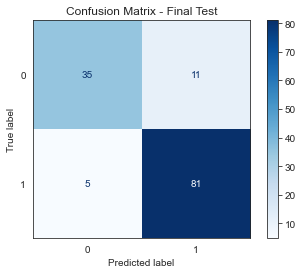

In [29]:
# Convert X_test to DMatrix
dtest = xgb.DMatrix(X_test)

# Make predictions (probabilities)
y_prob = best_model.predict(dtest)

# Apply 0.5 threshold to get binary classes
y_pred = (y_prob > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the results
print(f'Accuracy  : {acc:.3f}')
print(f'Precision : {prec:.3f}')
print(f'Recall    : {rec:.3f}')
print(f'F1-score  : {f1:.3f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Final Test")
plt.show()


## 🏁 Conclusion 

As mentioned earlier, we reused the same test set **just to demonstrate** how to load the model from MLflow.
To verify whether this is truly the **best-performing final model**, simply go to your MLflow experiment, check the corresponding **run ID**, and compare the logged **metrics** with the ones printed above.
